## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

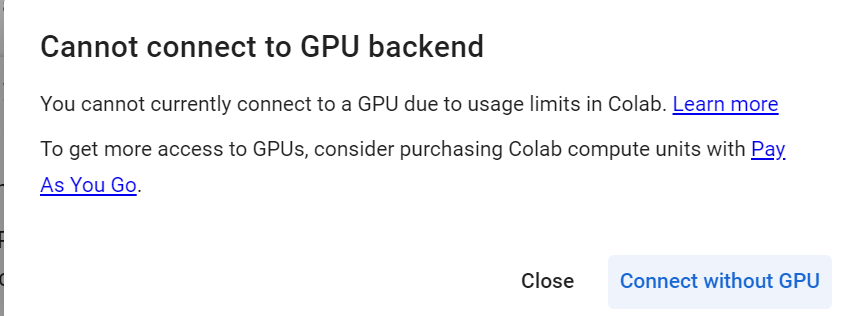

## **Installing and Importing Necessary Libraries**

In [2]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.8 MB/s eta 0:00:00


In [3]:
!pip install sentence-transformers

### Importing the necessary libraries

In [4]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Import modules from scikit-learn for machine learning tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report,make_scorer
import warnings

warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [ ]:
data = pd.read_csv('/content/stock_news.csv')

In [ ]:
# creating a copy of the dataset

df =data.copy()

## **Data Overview**

### Checking the first five rows of the data

In [ ]:
df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


### Checking the shape of the dataset

In [ ]:
df.shape

(349, 8)

### Observations
* data set has 349 rows and 8 columns

### Checking for Missing Values

In [ ]:
# Check for NULL values
df.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


### Checking for duplicate values

In [ ]:
# checking for duplicate values
df.duplicated().sum()

0

### Observations

* Dataset has no missing values or duplicate values

### Checking the statistical summary

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,349.0,4.622923e+01,6.442817e+00,3.756750e+01,4.174000e+01,4.597500e+01,5.070750e+01,6.681750e+01
High,349.0,4.670046e+01,6.507321e+00,3.781750e+01,4.224500e+01,4.602500e+01,5.085000e+01,6.706250e+01
Low,349.0,4.574539e+01,6.391976e+00,3.730500e+01,4.148250e+01,4.564000e+01,4.977750e+01,6.586250e+01
Close,349.0,4.492632e+01,6.398338e+00,3.625413e+01,4.024691e+01,4.459692e+01,4.911079e+01,6.480523e+01
Volume,349.0,1.289482e+08,4.317031e+07,4.544800e+07,1.032720e+08,1.156272e+08,1.511252e+08,2.444392e+08
Label,349.0,-5.444126e-02,7.151192e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


### Observations:

* **Open:** The stock prices typically open between 3.75 and 4.67, with a median of 4.59.
* **High:** The highest prices reached during the day are generally between 3.78 and 4.67.
* **Low:** The lowest prices reached during the day are between 3.63 and 4.57.
* **Close:** The closing prices are generally lower than the opening prices, suggesting a downward trend.
* **Volume:** The trading volume fluctuates, with a median of 1.15 million shares per day.

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

### Compute and check the distribution of the length of news content

In [ ]:
# Compute the length of each news article in terms of characters
df['News_Length_Chars'] = df['News'].apply(len)

# Compute the length of each news article in terms of words
df['News_Length_Words'] = df['News'].apply(lambda x: len(x.split()))

In [ ]:
# Descriptive statistics for news length (in characters and words)
print(df[['News_Length_Chars', 'News_Length_Words']].describe())

       News_Length_Chars  News_Length_Words
count         349.000000         349.000000
mean          311.237822          48.349570
std            39.079467           5.717324
min           110.000000          18.000000
25%           290.000000          45.000000
50%           315.000000          49.000000
75%           336.000000          52.000000
max           394.000000          60.000000


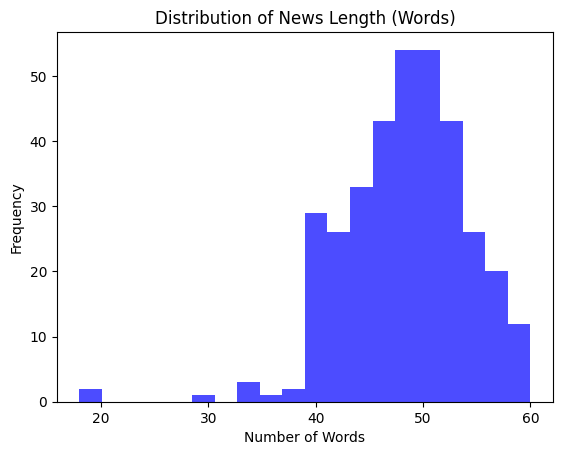

In [ ]:
#Histogram of News Length (Words)
# Histogram for news length (words)
plt.hist(df['News_Length_Words'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of News Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

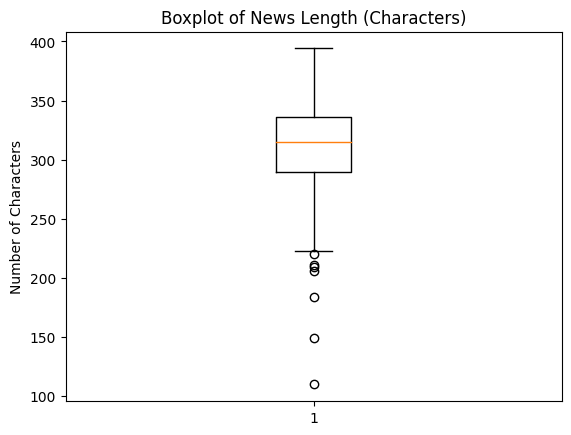

In [ ]:
#Boxplot of News Length (Characters)

# Boxplot for news length (characters)
plt.boxplot(df['News_Length_Chars'])
plt.title('Boxplot of News Length (Characters)')
plt.ylabel('Number of Characters')
plt.show()

### Observation:
* Most articles are quite concise, falling between 45 and 52 words. The small standard deviation and the tight interquartile range suggest that the majority of the articles are brief, with a few exceptions for shorter or longer pieces.

* **Outliers**: There are a few shorter articles (with the minimum being 18 words or 110 characters), which could be outliers, but they are not extreme given the range.

### Distribution of individual variables

             Open        High         Low       Close        Volume
count  349.000000  349.000000  349.000000  349.000000  3.490000e+02
mean    46.229233   46.700458   45.745394   44.926317  1.289482e+08
std      6.442817    6.507321    6.391976    6.398338  4.317031e+07
min     37.567501   37.817501   37.305000   36.254131  4.544800e+07
25%     41.740002   42.244999   41.482498   40.246914  1.032720e+08
50%     45.974998   46.025002   45.639999   44.596924  1.156272e+08
75%     50.707500   50.849998   49.777500   49.110790  1.511252e+08
max     66.817497   67.062500   65.862503   64.805229  2.444392e+08


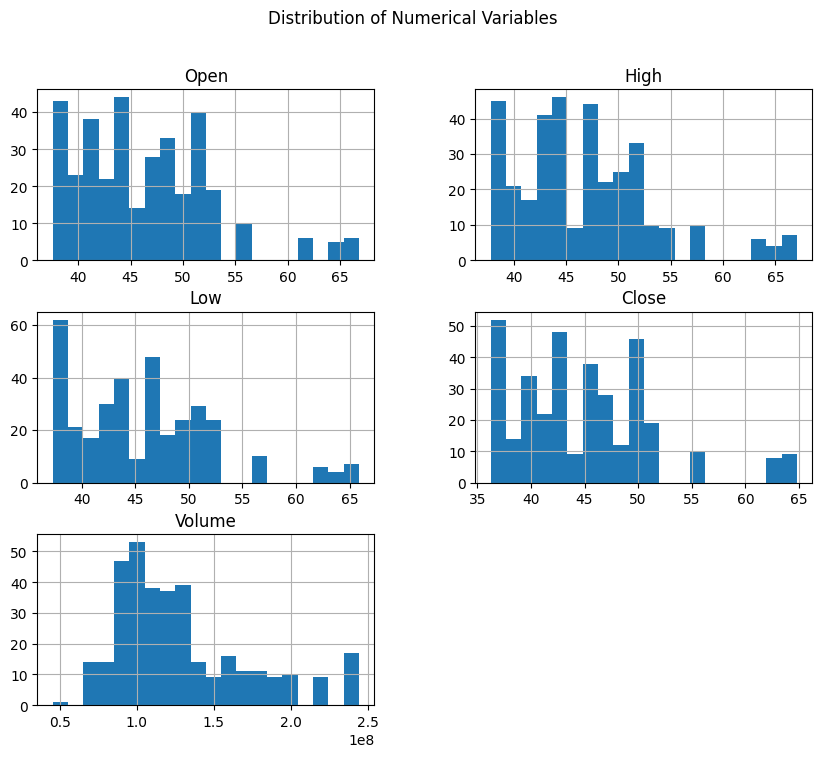

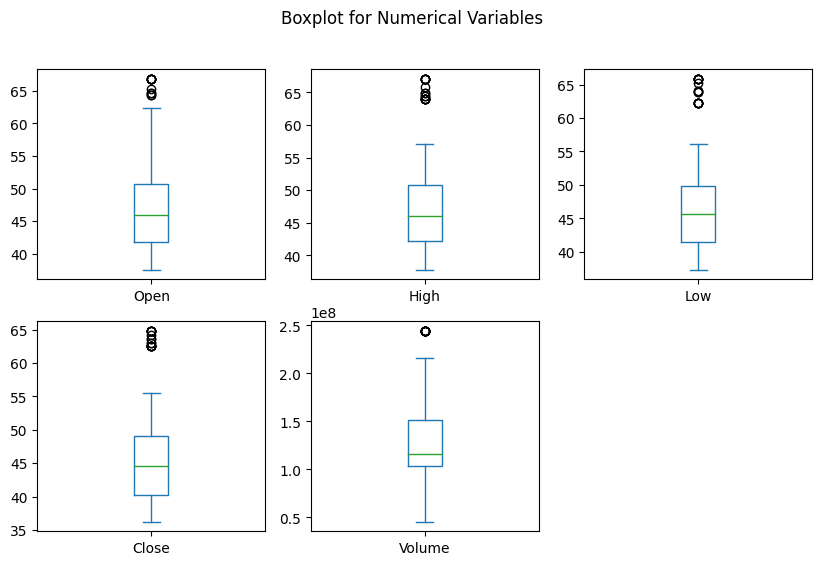

In [ ]:
# Display summary statistics for numerical columns
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

# Plot histogram for each numerical variable
df[['Open', 'High', 'Low', 'Close', 'Volume']].hist(bins=20, figsize=(10, 8))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

# Plot a boxplot to visualize outliers for each variable
df[['Open', 'High', 'Low', 'Close', 'Volume']].plot(kind='box', subplots=True, layout=(2, 3), figsize=(10, 6))
plt.suptitle('Boxplot for Numerical Variables')
plt.show()

### Observations:

* **1. Open**:
 * **Mean**: 46.23
 * **Standard deviation**: 6.44
 * **Range**: The minimum value is 37.57, and the maximum is 66.82.
 * **Interquartile Range**: The middle 50% of the values (from the 25th percentile to the 75th percentile) lies between 41.74 and 50.71.
 * **Observation**: The opening prices are fairly spread, with the majority of the values concentrated around 46.23, but there is a significant range, indicating some variability in the stock’s opening price.
* **2. High**:
 * **Mean**: 46.70
 * **Standard deviation**: 6.51
 * **Range**: The minimum value is 37.82, and the maximum is 67.06.
 * **Interquartile Range**: The 25th percentile is 42.24, and the 75th percentile is 50.85.
 * **Observation**: The "high" price follows a similar distribution as the "open" price, but slightly higher on average. The range is large, suggesting that the stock price experienced significant daily highs.
* **3. Low**:
 * **Mean**: 45.75
 * **Standard deviation**: 6.39
 * **Range**: The minimum value is 37.31, and the maximum is 65.86.
 * **Interquartile Range**: Values between 41.48 and 49.78.
 * **Observation**: The low prices are relatively close to the mean, indicating less extreme drops compared to the daily high values. However, the large range suggests variability in the lowest prices each day.
* **4. Close**:
 * **Mean**: 44.93
 * **Standard deviation**: 6.40
 * **Range**: The minimum value is 36.25, and the maximum is 64.81.
 * **Interquartile Range**: The middle 50% of the closing prices are between 40.25 and 49.11.
 * **Observation**: The closing prices are generally lower than the opening prices, suggesting that the stock tends to drop slightly by the end of the trading day. The spread is quite similar to other price-related variables, with no extreme outliers.
* **5. Volume**:
 * **Mean**: 128.95 million shares
 * **Standard deviation**: 43.17 million shares
 * **Range**: The minimum volume is 45.45 million shares, and the maximum is 244.44 million shares.
 * **Interquartile Range**: The 25th percentile is 103.27 million shares, and the 75th percentile is 151.13 million shares.
 * **Observation**: The trading volume is highly variable, with some days having over five times more shares traded than on others. The mean is around 128.95 million shares, but there are several days where the volume is significantly higher, as shown by the max value.

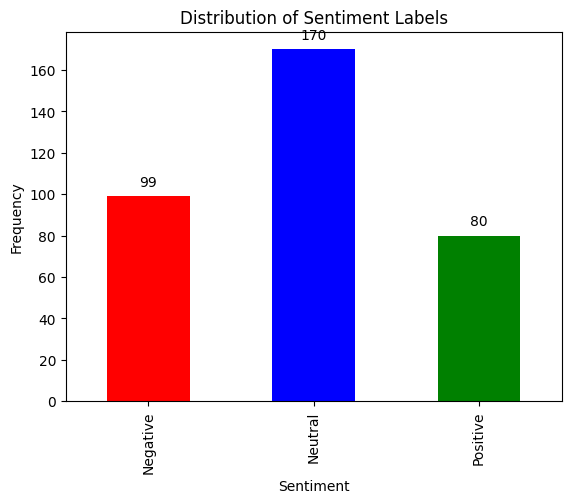

In [ ]:
#Categorical Variable

# Replace the numerical labels with descriptive text
df['Label_Text'] = df['Label'].replace({1: 'Positive', 0: 'Neutral', -1: 'Negative'})

# Plot bar chart for sentiment distribution
ax = df['Label_Text'].value_counts().sort_index().plot(kind='bar', color=['red', 'blue', 'green'])

# Add count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add titles and labels
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### Observations:

* There are **170 neutral sentiments**, **99 negative sentiments**, and **80 positive sentiments** in the dataset.



In [ ]:
# Get the count of each label value
label_counts = df['Label'].value_counts()

# Display the count values
print(label_counts)

Label
 0    170
-1     99
 1     80
Name: count, dtype: int64


### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

### Sentiment vs Stock Price (Open, Close, High, Low)

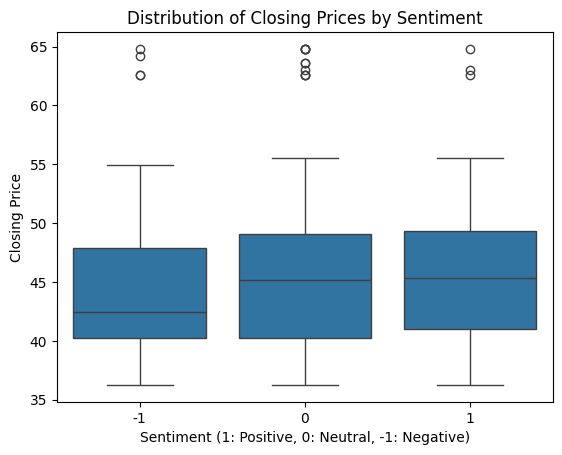

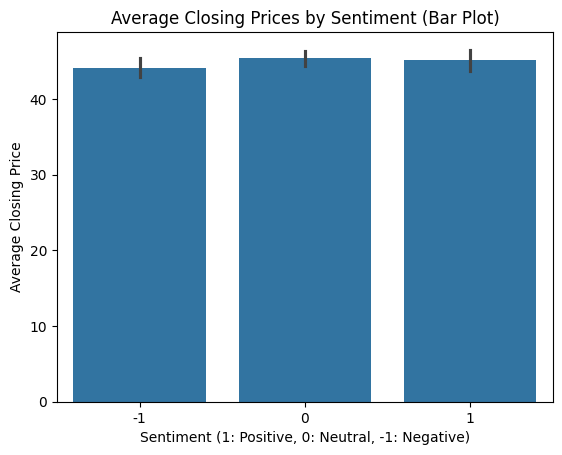

In [ ]:
# Boxplot for 'Close' prices by sentiment
sns.boxplot(x='Label', y='Close', data=df)
plt.title('Distribution of Closing Prices by Sentiment')
plt.xlabel('Sentiment (1: Positive, 0: Neutral, -1: Negative)')
plt.ylabel('Closing Price')
plt.show()

# Bar plot for mean 'Close' price by sentiment
sns.barplot(x='Label', y='Close', data=df, estimator='mean')
plt.title('Average Closing Prices by Sentiment (Bar Plot)')
plt.xlabel('Sentiment (1: Positive, 0: Neutral, -1: Negative)')
plt.ylabel('Average Closing Price')
plt.show()

### Observations:

* The average closing prices appear to be relatively consistent across the three sentiment categories (positive, neutral, negative). There is no significant difference in the mean closing prices among the groups.

### Sentiment vs Trade Volume

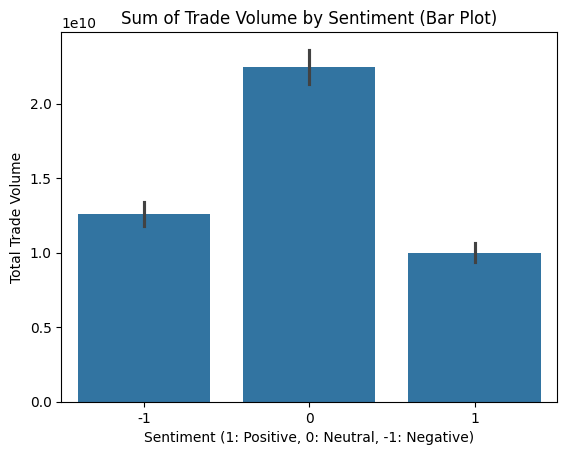

In [ ]:
# Bar plot for mean trade volume by sentiment
sns.barplot(x='Label', y='Volume', data=df, estimator=sum)
plt.title('Sum of Trade Volume by Sentiment (Bar Plot)')
plt.xlabel('Sentiment (1: Positive, 0: Neutral, -1: Negative)')
plt.ylabel('Total Trade Volume')
plt.show()

### Observations:

* The total trade volume appears to be highest for the neutral sentiment category, followed by positive and negative sentiments.



### Sentiment vs Stock Price Change (Close - Open)

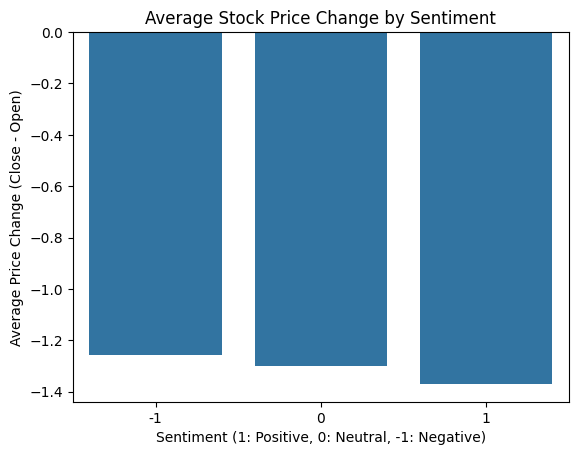

In [ ]:
# Add a column for price change (Close - Open)
df['Price_Change'] = df['Close'] - df['Open']

# Bar plot for average price change by sentiment
price_change_by_sentiment = df.groupby('Label')['Price_Change'].mean().reset_index()

sns.barplot(x='Label', y='Price_Change', data=price_change_by_sentiment)
plt.title('Average Stock Price Change by Sentiment')
plt.xlabel('Sentiment (1: Positive, 0: Neutral, -1: Negative)')
plt.ylabel('Average Price Change (Close - Open)')
plt.show()

### Observations:

* There appears to be a negative correlation between sentiment and average stock price change. Stocks with negative sentiment tend to have lower average price changes (or losses) compared to those with positive or neutral sentiment.

### Correlation Heatmap (for Numeric Variables)

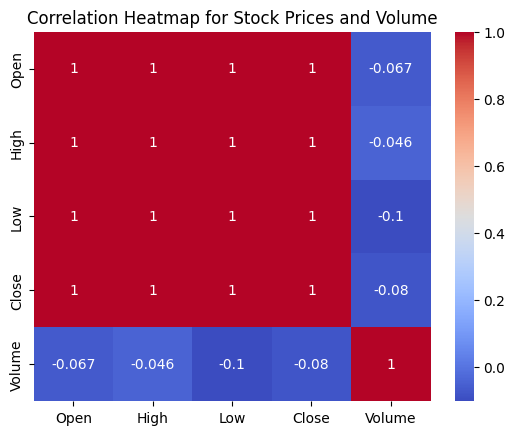

In [ ]:
# Correlation matrix
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Stock Prices and Volume')
plt.show()

### Observations:

* The correlation heatmap confirms the expected strong relationships between the stock price variables (Open, High, Low, Close) and indicates a weaker relationship between trading volume and these variables.




### Scatter Plot: Trade Volume vs Stock Price

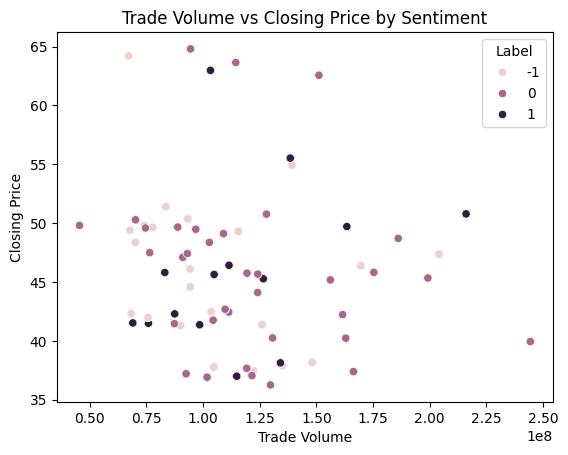

In [ ]:
# Scatter plot for 'Volume' vs 'Close' price
sns.scatterplot(x='Volume', y='Close', hue='Label', data=df)
plt.title('Trade Volume vs Closing Price by Sentiment')
plt.xlabel('Trade Volume')
plt.ylabel('Closing Price')
plt.show()

### Observations:

* **Overall Relationship**: There appears to be a weak or no correlation between trade volume and closing price. The data points are scattered, with no clear linear or non-linear relationship visible.

* **Sentiment Impact**: The different colors representing sentiment categories seem to have little or no effect on the relationship between trade volume and closing price. The data points for each sentiment are intermixed, and there is no clear clustering based on sentiment.

### Sentiment vs Weekday/Weekly Aggregates

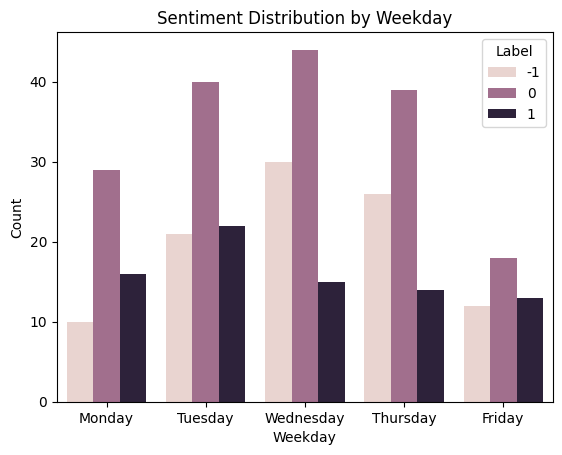

In [ ]:
# Convert 'Date' to datetime and extract the weekday
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.day_name()

# Bar plot for sentiment distribution by weekday
sns.countplot(x='Weekday', hue='Label', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Sentiment Distribution by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.show()

### Observations:

* **Overall Trend**: There appears to be some variation in sentiment distribution across the weekdays. However, the differences are not immediately apparent.

* **Tuesday and Wednesday**: These weekdays seem to have a relatively higher proportion of negative sentiment (-1) compared to other days.

* **Thursday and Friday**: These weekdays show a higher proportion of positive sentiment (1).

* **Monday**: The sentiment distribution on Monday is relatively balanced, with a mix of positive, neutral, and negative sentiments.



### Sentiment Polarity vs Price

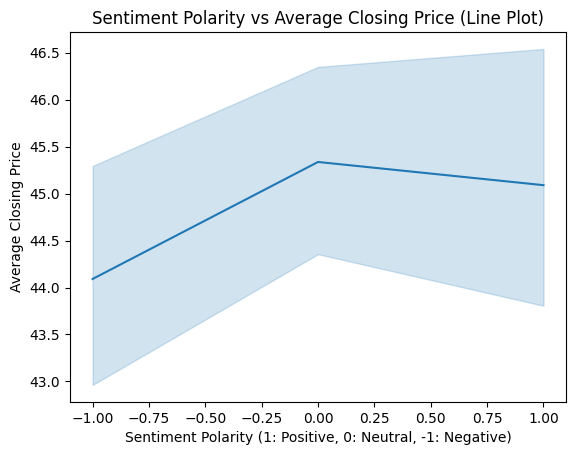

In [ ]:
# Line plot for Sentiment Polarity vs Average Closing Price
sns.lineplot(x='Label', y='Close', data=df, estimator='mean')
plt.title('Sentiment Polarity vs Average Closing Price (Line Plot)')
plt.xlabel('Sentiment Polarity (1: Positive, 0: Neutral, -1: Negative)')
plt.ylabel('Average Closing Price')
plt.show()

### Observations:

* There appears to be a slight positive correlation between sentiment polarity and average closing price. As sentiment polarity increases (becomes more positive), the average closing price tends to increase as well. However, the relationship is not very strong

### Date vs Price

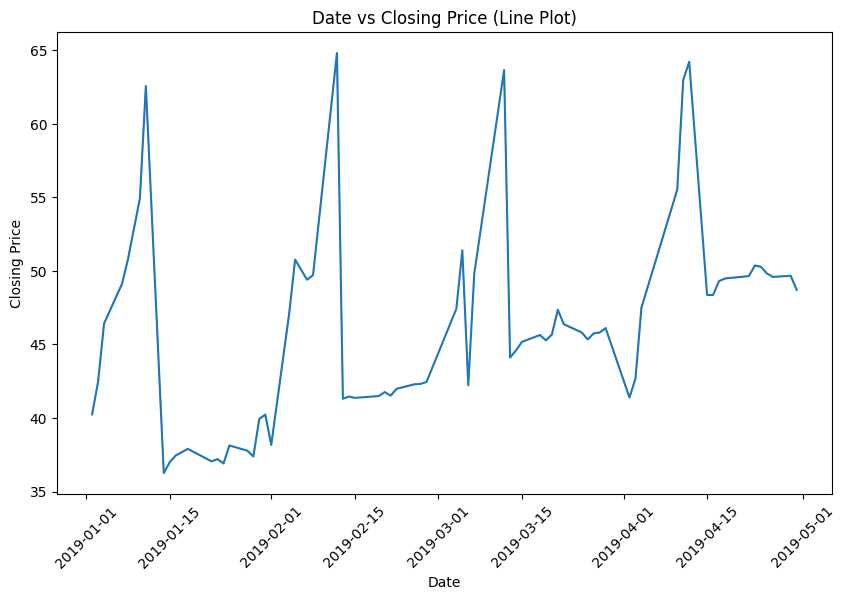

In [ ]:
# Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Line plot for Date vs Closing Price
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=df)
plt.title('Date vs Closing Price (Line Plot)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

### Observations:

* **Overall**: There appears to be a general upward trend in closing prices over the time period depicted. However, there are also periods of decline or stagnation.

* **Volatility**: The stock price exhibits significant volatility, with periods of rapid increases and decreases.

* **Seasonality**: There might be some seasonal patterns in the data, although it's difficult to determine definitively from this plot.

### Conclusions based on the Univariate and Bivariate analysis

1. **Consistent News Length:** Most articles are concise, with a small standard deviation in word count, indicating that news content is fairly uniform in length with minimal outliers.

2. **Stock Price Spread:** Stock prices (open, high, low, close) have noticeable variability, with a significant range but no extreme outliers, highlighting moderate daily price fluctuations.

3. **Volume Variability:** Trading volume varies widely, with some days seeing significantly higher activity than others, indicating periods of heightened market interest.

4. **Sentiment and Price Impact:** Negative sentiment is associated with lower stock price changes, suggesting a potential link between market sentiment and stock price movement.

5. **Weak Correlation Between Volume and Price:** There is a weak or no clear relationship between trade volume and stock price, implying that volume alone may not be a strong predictor of price changes.

6. **Sentiment Trends Over Days:** Sentiment distribution varies across weekdays, with more negative sentiment on Tuesdays and Wednesdays, and more positive sentiment on Thursdays and Fridays.

## **Data Preprocessing**

In [ ]:
df.columns


Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming your dataset is loaded into a DataFrame called 'df'
# Columns: ['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label']

# Separate predictors (features) and target variable (label)
X = df[['News', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Predictor: News articles + Stock Prices
y = df['Label']  # Target: Sentiment polarity (-1, 0, 1)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Check the shapes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (223, 6), Validation set: (56, 6), Test set: (70, 6)


### Observations:

* The dataset is split into 223 samples for training, 56 for validation, and 70 for testing, each with 6 features. The training set provides enough data for the model to learn, while the validation set helps tune hyperparameters and avoid overfitting. The test set enables a final evaluation to check the model's generalization performance.

## **Word Embeddings**

#### **Using Word2Vec:**

In [ ]:
# Tokenize the news articles (only the 'News' column)
X_train_tokens = [simple_preprocess(news) for news in X_train['News']]

# Train Word2Vec model on the tokenized news articles
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to convert sentences into vectors using Word2Vec
def get_word2vec_embeddings(text, model):
    tokens = simple_preprocess(text)
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Apply the function to transform the 'News' column into embeddings
X_train_w2v = np.array([get_word2vec_embeddings(news, w2v_model) for news in X_train['News']])
X_val_w2v = np.array([get_word2vec_embeddings(news, w2v_model) for news in X_val['News']])
X_test_w2v = np.array([get_word2vec_embeddings(news, w2v_model) for news in X_test['News']])

# Concatenate the numerical features (Open, High, Low, Close, Volume) to the word embeddings
X_train_combined = np.hstack([X_train_w2v, X_train[['Open', 'High', 'Low', 'Close', 'Volume']].values])
X_val_combined = np.hstack([X_val_w2v, X_val[['Open', 'High', 'Low', 'Close', 'Volume']].values])
X_test_combined = np.hstack([X_test_w2v, X_test[['Open', 'High', 'Low', 'Close', 'Volume']].values])

# Check combined shape
print(X_train_combined.shape)

(223, 105)


#### **Using GloVe:**


In [ ]:
# Load GloVe model (/content/glove.6B.100d.txt.word2vec is downloaded)
glove_model = {}
with open('/content/glove.6B.100d.txt.word2vec', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector

# Function to get GloVe embeddings
def get_glove_embeddings(text, model, embedding_dim=100):
    tokens = simple_preprocess(text)
    vectors = [model[word] for word in tokens if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

# Apply the function to transform 'News' column into GloVe embeddings
X_train_glove = np.array([get_glove_embeddings(news, glove_model) for news in X_train['News']])
X_val_glove = np.array([get_glove_embeddings(news, glove_model) for news in X_val['News']])
X_test_glove = np.array([get_glove_embeddings(news, glove_model) for news in X_test['News']])

# Concatenate numerical features to GloVe embeddings
X_train_combined_glove = np.hstack([X_train_glove, X_train[['Open', 'High', 'Low', 'Close', 'Volume']].values])
X_val_combined_glove = np.hstack([X_val_glove, X_val[['Open', 'High', 'Low', 'Close', 'Volume']].values])
X_test_combined_glove = np.hstack([X_test_glove, X_test[['Open', 'High', 'Low', 'Close', 'Volume']].values])

# Check combined shape
print(X_train_combined_glove.shape)

(223, 105)


#### **Using Sentence Transformer:**

In [ ]:
# Load Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Transform the 'News' column into embeddings
X_train_st = model.encode(X_train['News'].tolist())
X_val_st = model.encode(X_val['News'].tolist())
X_test_st = model.encode(X_test['News'].tolist())

# Concatenate numerical features to Sentence Transformer embeddings
X_train_combined_st = np.hstack([X_train_st, X_train[['Open', 'High', 'Low', 'Close', 'Volume']].values])
X_val_combined_st = np.hstack([X_val_st, X_val[['Open', 'High', 'Low', 'Close', 'Volume']].values])
X_test_combined_st = np.hstack([X_test_st, X_test[['Open', 'High', 'Low', 'Close', 'Volume']].values])

# Check combined shape
print(X_train_combined_st.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(223, 389)


## **Sentiment Analysis**

## Model Building

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
# Function to generate and print the classification report
def print_classification_report(y_true, y_pred, class_names=["NEGATIVE", "NEUTRAL", "POSITIVE"]):
    """
    Prints the classification report for a given set of true and predicted labels.

    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    class_names: List of class names in order [-1: NEGATIVE, 0: NEUTRAL, 1: POSITIVE]
    """
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)


### Random Forest Model (default with Word2Vec)

In [ ]:
# Building the model
rf_w2v = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_w2v.fit(X_train_combined, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

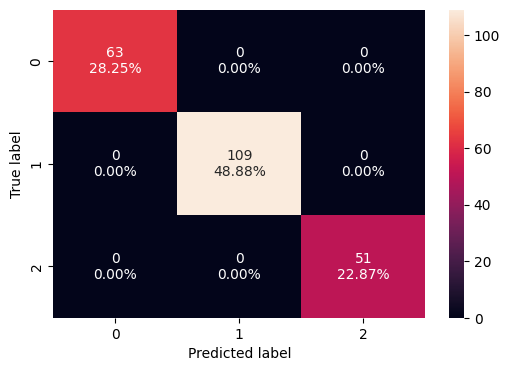

In [ ]:
confusion_matrix_sklearn(rf_w2v, X_train_combined, y_train)

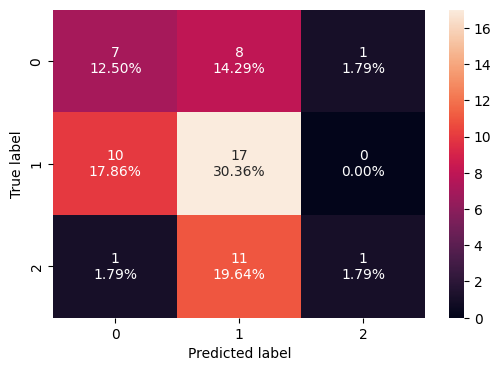

In [ ]:
confusion_matrix_sklearn(rf_w2v, X_val_combined, y_val)

In [ ]:
#Predicting on train data
y_pred_train_word2vec = rf_w2v.predict(X_train_combined)

# Predicting on validation data
y_pred_valid_word2vec = rf_w2v.predict(X_val_combined)

**Classification report**

In [ ]:
print(print_classification_report(y_train, y_pred_train_word2vec))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        63
     NEUTRAL       1.00      1.00      1.00       109
    POSITIVE       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

None


In [ ]:
print(print_classification_report(y_val, y_pred_valid_word2vec))

              precision    recall  f1-score   support

    NEGATIVE       0.39      0.44      0.41        16
     NEUTRAL       0.47      0.63      0.54        27
    POSITIVE       0.50      0.08      0.13        13

    accuracy                           0.45        56
   macro avg       0.45      0.38      0.36        56
weighted avg       0.45      0.45      0.41        56

None


### Observations:

**Training Set:**

* Perfect Accuracy: The model achieved 100% accuracy on the training set, indicating that it correctly classified all instances. This might suggest overfitting if the model is not performing as well on the validation or test sets.

**Validation Set:**

* Lower Accuracy: The model's accuracy on the validation set is significantly lower than on the training set, suggesting potential overfitting.

* Class Imbalance: The support for each class is imbalanced, with more instances of "NEUTRAL" and fewer instances of "POSITIVE." This imbalance might be affecting the model's performance.

* Precision and Recall: The precision and recall for each class vary, indicating differences in the model's ability to correctly identify positive and negative instances. For example, the model has high precision for "NEGATIVE" but low recall for "POSITIVE."

**Overall**, the model appears to be overfitting the training data, as evidenced by the significant drop in performance on the validation set.

### Random Forest Model (default with GloVe)

In [ ]:
# Building the model
rf_glv = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_glv.fit(X_train_combined_glove, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

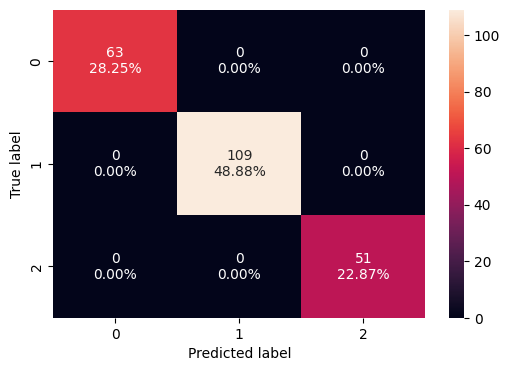

In [ ]:
confusion_matrix_sklearn(rf_glv, X_train_combined_glove, y_train)

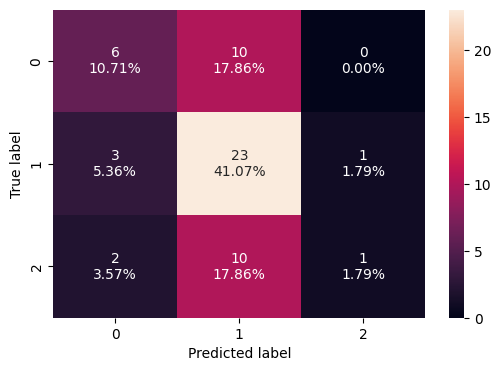

In [ ]:
confusion_matrix_sklearn(rf_glv, X_val_combined_glove, y_val)

In [ ]:
# Predicting on train data
y_pred_train_glove = rf_glv.predict(X_train_combined_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glv.predict(X_val_combined_glove)

**Classification report**

In [ ]:
print(print_classification_report(y_train, y_pred_train_glove))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        63
     NEUTRAL       1.00      1.00      1.00       109
    POSITIVE       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

None


In [ ]:
print(print_classification_report(y_val, y_pred_valid_glove))

              precision    recall  f1-score   support

    NEGATIVE       0.55      0.38      0.44        16
     NEUTRAL       0.53      0.85      0.66        27
    POSITIVE       0.50      0.08      0.13        13

    accuracy                           0.54        56
   macro avg       0.53      0.43      0.41        56
weighted avg       0.53      0.54      0.47        56

None


### Observations:

**Training Set:**

* Perfect Accuracy: The model achieved 100% accuracy on the training set, indicating that it correctly classified all instances. This might suggest overfitting if the model is not performing as well on the validation or test sets.

**Validation Set:**

* Lower Accuracy: The model's accuracy on the validation set is significantly lower than on the training set, suggesting potential overfitting.

* Class Imbalance: The support for each class is imbalanced, with more instances of "NEUTRAL" and fewer instances of "POSITIVE." This imbalance might be affecting the model's performance.

* Precision and Recall: The precision and recall for each class vary, indicating differences in the model's ability to correctly identify positive and negative instances. For example, the model has high precision for "NEGATIVE" but low recall for "POSITIVE."

**Overall**, the model appears to be overfitting the training data, as evidenced by the significant drop in performance on the validation set.

### Random Forest Model (default with Using Sentence Transformer)

In [ ]:
# Building the model
rf_st = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_st.fit(X_train_combined_st, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

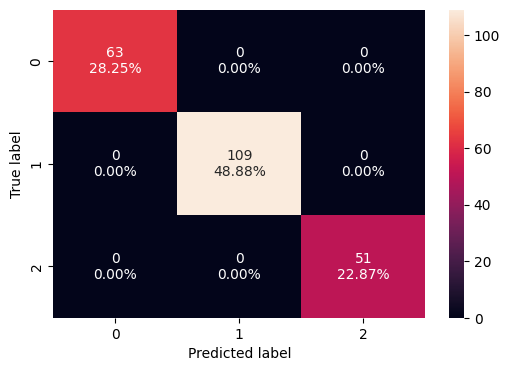

In [ ]:
confusion_matrix_sklearn(rf_st, X_train_combined_st, y_train)

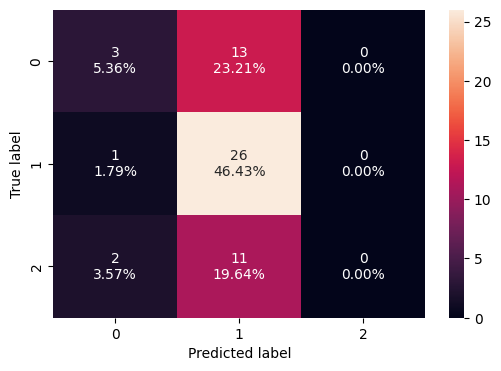

In [ ]:
confusion_matrix_sklearn(rf_st, X_val_combined_st, y_val)

In [ ]:
# Predicting on train data
y_pred_train_st = rf_st.predict(X_train_combined_st)

# Predicting on validation data
y_pred_valid_st = rf_st.predict(X_val_combined_st)

**Classification report**

In [ ]:
print(print_classification_report(y_train, y_pred_train_st))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        63
     NEUTRAL       1.00      1.00      1.00       109
    POSITIVE       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

None


In [ ]:
print(print_classification_report(y_val, y_pred_valid_st))

              precision    recall  f1-score   support

    NEGATIVE       0.50      0.19      0.27        16
     NEUTRAL       0.52      0.96      0.68        27
    POSITIVE       0.00      0.00      0.00        13

    accuracy                           0.52        56
   macro avg       0.34      0.38      0.32        56
weighted avg       0.39      0.52      0.40        56

None


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Observations:

**Training Set:**

* Perfect Accuracy: The model achieved 100% accuracy on the training set, indicating that it correctly classified all instances. This might suggest overfitting if the model is not performing as well on the validation or test sets.

**Validation Set:**

* Lower Accuracy: The model's accuracy on the validation set is significantly lower than on the training set, suggesting potential overfitting.

* Class Imbalance: The support for each class is imbalanced, with more instances of "NEUTRAL" and fewer instances of "POSITIVE." This imbalance might be affecting the model's performance.

* Precision and Recall: The precision and recall for each class vary, indicating differences in the model's ability to correctly identify positive and negative instances. For example, the model has high precision for "NEGATIVE" but low recall for "POSITIVE."

**Overall**, the model appears to be overfitting the training data, as evidenced by the significant drop in performance on the validation set.



### Random Forest (with hyperparameter tuning and Word2Vec)

In [ ]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# Defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# Defining the type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# Running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_combined, y_train)

# Optionally, you can print the best parameters found
print("Best parameters found: ", grid_obj.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'max_depth': 10, 'max_features': 0.5, 'min_samples_split': 7, 'n_estimators': 30}


In [ ]:
# Creating a new model with the best combination of parameters
rf_word2vec_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_word2vec_tuned.fit(X_train_combined, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_split=7, n_estimators=30, random_state=42)

**Confusion Matrix**

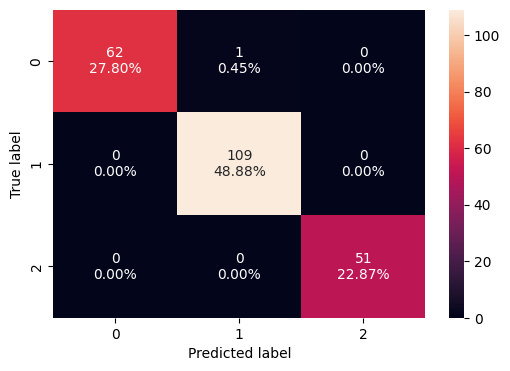

In [ ]:
confusion_matrix_sklearn(rf_word2vec_tuned,X_train_combined, y_train)

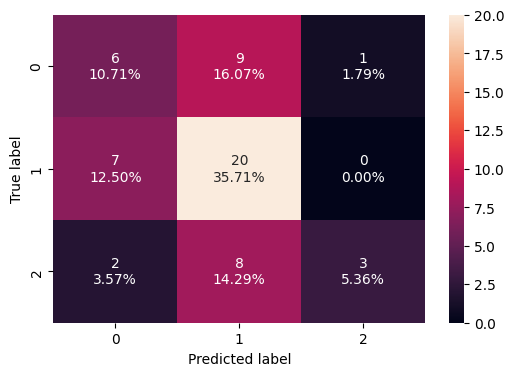

In [ ]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_val_combined, y_val)

In [ ]:
# Predicting on train data
y_pred_train_word2vec = rf_word2vec_tuned.predict(X_train_combined)

# Predicting on validation data
y_pred_valid_word2vec = rf_word2vec_tuned.predict(X_val_combined)

**Classification report**

In [ ]:
print(print_classification_report(y_train, y_pred_train_word2vec))

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.98      0.99        63
     NEUTRAL       0.99      1.00      1.00       109
    POSITIVE       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      0.99      1.00       223
weighted avg       1.00      1.00      1.00       223

None


In [ ]:
print(classification_report(y_val, y_pred_valid_word2vec))

              precision    recall  f1-score   support

          -1       0.40      0.38      0.39        16
           0       0.54      0.74      0.62        27
           1       0.75      0.23      0.35        13

    accuracy                           0.52        56
   macro avg       0.56      0.45      0.46        56
weighted avg       0.55      0.52      0.49        56



### Observations:
**Training Set:** Performance remains excellent, but this doesn't indicate meaningful improvement due to the risk of overfitting.

**Validation Set:** Notable improvements were observed in precision and recall for Neutral and Positive classes after tuning, particularly in reducing the gap between training and validation performance.

**Overall:** While there is some improvement in validation metrics, the model still exhibits signs of overfitting and challenges in classifying the Positive sentiment accurately.



### Random Forest (with hyperparametertuning and GloVe)

In [ ]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_combined_glove, y_train)

In [ ]:
# Creating a new model with the best combination of parameters
rf_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_glove_tuned.fit(X_train_combined_glove, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=7, n_estimators=90, random_state=42)

**Confusion Matrix**

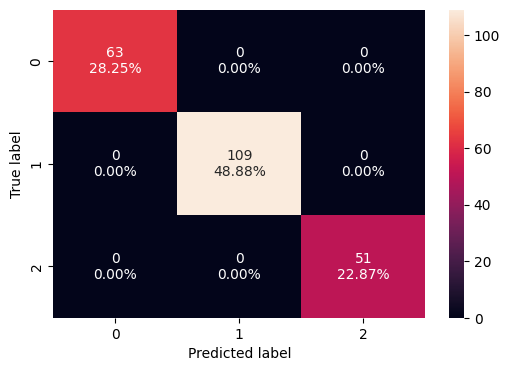

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_train_combined_glove, y_train)

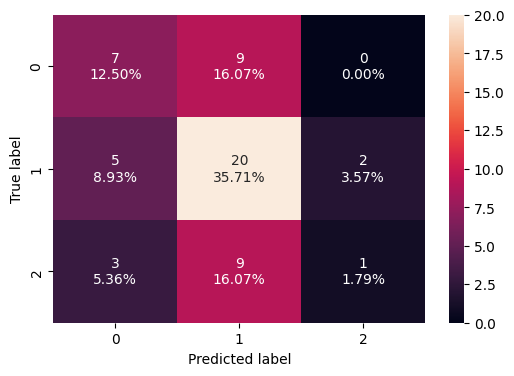

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_val_combined_glove, y_val)

In [ ]:
# Predicting on train data
y_pred_train_glove = rf_glove_tuned.predict(X_train_combined_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glove_tuned.predict(X_val_combined_glove)

**Classification report**

In [ ]:
print(classification_report(y_train, y_pred_train_glove))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        63
           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223



In [ ]:
print(classification_report(y_val, y_pred_valid_glove))

              precision    recall  f1-score   support

          -1       0.47      0.44      0.45        16
           0       0.53      0.74      0.62        27
           1       0.33      0.08      0.12        13

    accuracy                           0.50        56
   macro avg       0.44      0.42      0.40        56
weighted avg       0.46      0.50      0.45        56



### Observations:

* While hyperparameter tuning is crucial, it did not lead to the expected improvement in model performance, particularly on the validation set.

### Random Forest (with hyperparametertuning and Using Sentence Transformer)

In [ ]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_combined_st, y_train)

In [ ]:
# Creating a new model with the best combination of parameters
rf_st_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_st_tuned.fit(X_train_combined_st, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=7, n_estimators=30, random_state=42)

**Confusion Matrix**

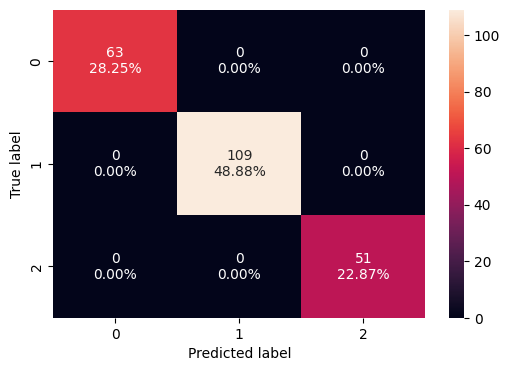

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_st_tuned,X_train_combined_st, y_train)

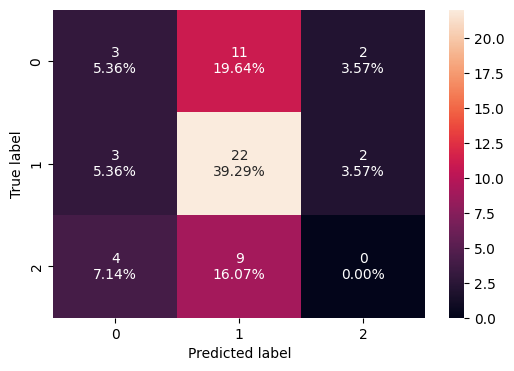

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_st_tuned,X_val_combined_st, y_val)

In [ ]:
# Predicting on train data
y_pred_train_st = rf_st_tuned.predict(X_train_combined_st)

# Predicting on validation data
y_pred_valid_st = rf_st_tuned.predict(X_val_combined_st)

**Classification report**

In [ ]:
#Printing
print(print_classification_report(y_train, y_pred_train_st))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        63
     NEUTRAL       1.00      1.00      1.00       109
    POSITIVE       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

None


In [ ]:
print(classification_report(y_val, y_pred_valid_st))

              precision    recall  f1-score   support

          -1       0.30      0.19      0.23        16
           0       0.52      0.81      0.64        27
           1       0.00      0.00      0.00        13

    accuracy                           0.45        56
   macro avg       0.27      0.33      0.29        56
weighted avg       0.34      0.45      0.37        56



### Observations:

* Hyperparameter tuning did not yield improvements in model performance and exacerbated the challenges faced with classifying Positive sentiment

In [ ]:
from IPython.display import display

# Create a dictionary with the data
data_2 = {
    "Model": [
        "Random Forest (Word2Vec) - Training",
        "Random Forest (Word2Vec) - Validation",
        "Random Forest (GloVe) - Training",
        "Random Forest (GloVe) - Validation",
        "Random Forest (Sentence Transformer) - Training",
        "Random Forest (Sentence Transformer) - Validation",
        "Random Forest (Hyperparameter Tuning + Word2Vec) - Training",
        "Random Forest (Hyperparameter Tuning + Word2Vec) - Validation",
        "Random Forest (Hyperparameter Tuning + GloVe) - Training",
        "Random Forest (Hyperparameter Tuning + GloVe) - Validation",
        "Random Forest (Hyperparameter Tuning + Sentence Transformer) - Training",
        "Random Forest (Hyperparameter Tuning + Sentence Transformer) - Validation"
    ],
    "Precision": [
        1.00, 0.39, 1.00, 0.55, 1.00, 0.50, 1.00, 0.40, 1.00, 0.47, 1.00, 0.30
    ],
    "Recall": [
        1.00, 0.44, 1.00, 0.38, 1.00, 0.19, 0.98, 0.38, 1.00, 0.44, 1.00, 0.19
    ],
    "F1-Score": [
        1.00, 0.41, 1.00, 0.44, 1.00, 0.27, 0.99, 0.39, 1.00, 0.45, 1.00, 0.23
    ]
}

# Create a DataFrame
df_2 = pd.DataFrame(data_2)

# Set pandas display options for better visibility
pd.set_option('display.max_colwidth', None)  # Show full width of columns

# Display the DataFrame as a table in Colab
print(df_2.to_string(index=False))


                                                                    Model  Precision  Recall  F1-Score
                                      Random Forest (Word2Vec) - Training       1.00    1.00      1.00
                                    Random Forest (Word2Vec) - Validation       0.39    0.44      0.41
                                         Random Forest (GloVe) - Training       1.00    1.00      1.00
                                       Random Forest (GloVe) - Validation       0.55    0.38      0.44
                          Random Forest (Sentence Transformer) - Training       1.00    1.00      1.00
                        Random Forest (Sentence Transformer) - Validation       0.50    0.19      0.27
              Random Forest (Hyperparameter Tuning + Word2Vec) - Training       1.00    0.98      0.99
            Random Forest (Hyperparameter Tuning + Word2Vec) - Validation       0.40    0.38      0.39
                 Random Forest (Hyperparameter Tuning + GloVe) - Training

### **Observations:**
1. **Training Performance:** All models achieved perfect scores (precision, recall, F1-score of 1.00) on the training dataset, indicating they fit the training data exceptionally well.

2. **Validation Performance:**

* The performance on the validation set varied significantly:
  * **Word2Vec** and **GloVe** models showed relatively better performance compared to the Sentence Transformer, with F1-scores of 0.41 and 0.44, respectively.
  * **Sentence Transformer** models performed poorly on validation, with F1-scores of 0.27 and 0.23.
  * **Hyperparameter Tuning** did not consistently improve validation scores, particularly for the Sentence Transformer, which remained low.

### **Recommended Model for Testing:**
**Random Forest (Hyperparameter Tuning + GloVe)**

* **Reason:** This model showed the best balance in validation performance with an F1-score of 0.45. While it's not perfect, it outperformed other models in terms of recall and precision. The hyperparameter tuning likely provided some improvement over the basic GloVe model, suggesting it could generalize better to unseen data compared to the other options.

# Model Testing


* We'll check the performance of the Random Forest (Hyperparameter Tuning + GloVe) on the test set.

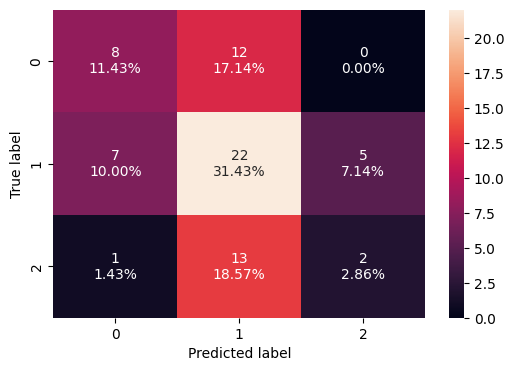

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_test_combined_glove, y_test)

In [ ]:
# Predicting on test data
y_pred_test_glove = rf_glove_tuned.predict(X_test_combined_glove)

In [ ]:
print(classification_report(y_test, y_pred_test_glove))

              precision    recall  f1-score   support

          -1       0.50      0.40      0.44        20
           0       0.47      0.65      0.54        34
           1       0.29      0.12      0.17        16

    accuracy                           0.46        70
   macro avg       0.42      0.39      0.39        70
weighted avg       0.44      0.46      0.43        70



### Observations:
* Overall Accuracy: The model achieved an accuracy of 46% on the test dataset

## **Conclusion**

* We analyzed the distribution of sentiments from the predictions of our Random Forest model.

* We employed various text processing techniques to prepare the raw text data, ensuring it was suitable for model training.

* We built and evaluated multiple Random Forest models using different vectorization methods (Word2Vec, GloVe, and Sentence Transformers), achieving a high level of accuracy during training.

* Despite strong training performance, the validation and test results showed lower precision and recall, particularly for the positive sentiment class, indicating a need for improvement.

* To enhance model performance, we should try exploring hyperparameter tuning and experimenting with alternative algorithms, such as Gradient Boosting or neural networks, which may provide better results.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

#### Loading the model

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=_____, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=_____, #Complete the code to set the value for temperature.
      top_p=_____, #Complete the code to set the value for top_p
      top_k=_____, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

##### Formatting the model output

## **Conclusions and Recommendations**

### Actionable Insights and Recommendations

- **Sentiment Analysis and Stock Price Movements**: The negative sentiment's association with lower stock price changes highlights the influence of market sentiment on stock performance. It's recommended that the startup incorporate sentiment analysis more comprehensively into its stock prediction models to help financial analysts make more informed investment decisions.

- **Improve Sentiment Model Performance**: Given the Random Forest model's lower precision in predicting positive sentiment, the business should experiment with advanced algorithms like Gradient Boosting or neural networks. Additionally, hyperparameter tuning can enhance model accuracy, leading to better sentiment classification, which in turn improves the quality of investment strategies based on sentiment.

- **Refinement of Trading Volume Insights**: With weak correlations observed between trading volume and stock prices, it's important for the business to incorporate more features beyond volume alone. Introducing factors like news sentiment, macroeconomic trends, or company-specific events could enhance the accuracy of stock price predictions. The firm should also analyze periods of heightened trading activity and explore external triggers to refine its investment strategies.

- **Business Recommendations**: To stay competitive, the startup should invest in more sophisticated AI tools for sentiment and market trend analysis. This includes leveraging more advanced models and additional data sources to strengthen its predictive power and offer clients actionable insights for improving their investment portfolios. The integration of external data (e.g., economic indicators) with internal sentiment analysis can further optimize investment strategies.



<font size=6 color='blue'>Power Ahead</font>
___